## Data Import from Kaggle

In [1]:
#In Colab, you need to install the Kaggle library.
!pip install -q kaggle;

In [2]:
# json token file
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [3]:
#Move the uploaded kaggle.json file to the appropriate directory.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#list of datasets with the word alzheimers
!kaggle datasets list -s alzheimers
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
! mkdir Omdena
! unzip alzheimers-dataset-4-class-of-images.zip -d Omdena/

In [5]:
# Import libraries
from keras.preprocessing.image import ImageDataGenerator
import os
import time
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
import random

# The random seed
seed_value = 354179905

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

## Model Training

## Particle Swarm Optimizer

1.   Paper: [Optimization of Convolutional Neural Network Using the Linearly Decreasing Weight Particle Swarm Optimization](https://arxiv.org/abs/2001.05670)
2.   Library: [Hyperactive](https://https://github.com/SimonBlanke/Hyperactive)



In [ ]:
#Import Hyperactive
!pip install hyperactive

In [7]:
from hyperactive import Hyperactive
from hyperactive.optimizers import ParticleSwarmOptimizer, RandomSearchOptimizer
from hyperactive.optimizers.strategies import CustomOptimizationStrategy

### Data Preprocessing

In [20]:
# Define path to the data directory
train_dir = "/content/Omdena/Alzheimer_s Dataset/train"

# Define image generator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescaling
    #brightness_range=[0.2,1.0],  # Brightness
    #zoom_range=0.2,  # Zooming
    #fill_mode='nearest',  # Filling
    #horizontal_flip=True,  # Flipping
    validation_split=0.2  # Setting the validation split to 20%
)

# Define image generator for validation with only rescaling
val_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescaling
    validation_split=0.2  # Setting the validation split to 20%
)

# Create a training data flow
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(176, 176),  # Set the target size to 150x150
    batch_size=32,
    class_mode="categorical",
    subset='training'  # Specify that this is the training data
)

# Create a validation data flow
val_data = val_datagen.flow_from_directory(
    train_dir,
    target_size=(176, 176),  # Set the target size to 150x150
    batch_size=32,
    class_mode="categorical",
    subset='validation'  # Specify that this is the validation data
)


Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


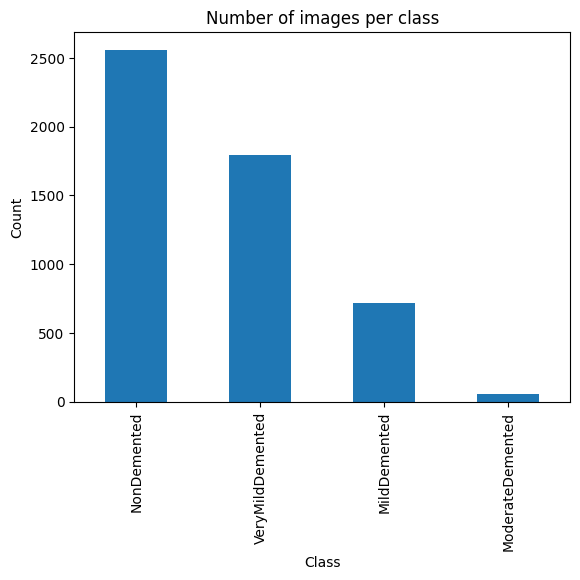

In [9]:
# Get list of all classes
classes = os.listdir(train_dir)

# Count number of images per class
counts = {}
for class_name in classes:
    counts[class_name] = len(os.listdir(os.path.join(train_dir, class_name)))

# Convert to DataFrame for easier plotting
df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])

# Create bar plot
df_counts.sort_values('count', ascending=False).plot(kind='bar', legend=False)
plt.title('Number of images per class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### CNN Model

In [25]:
def model(opt):
    # Define the model
    model = keras.Sequential([
        keras.layers.Conv2D(filters=opt["conv_filters"], kernel_size=opt["conv_kernel_size"], activation=opt["conv_activation"], input_shape=(176, 176, 3)),
        keras.layers.AveragePooling2D(),
        keras.layers.Conv2D(filters=opt["conv_filters"], kernel_size=opt["conv_kernel_size"], activation=opt["conv_activation"]),
        keras.layers.AveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(units=opt["dense_units"], activation=opt["dense_activation"]),
        keras.layers.Dense(units=opt["dense_units"], activation=opt["dense_activation"]),
        keras.layers.Dense(units=4, activation="softmax")
    ])
    # Instantiate an optimizer with a learning rate
    if opt["optimizer"] == "adam":
         optimizer = keras.optimizers.Adam(learning_rate=0.001)
    elif opt["optimizer"] == "sgd":
         optimizer = keras.optimizers.SGD(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=opt["optimizer"], loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    model.fit(train_data, epochs=opt["n_epochs"], batch_size=opt["batch_size"], verbose=2)

    # Evaluate the model
    score = model.evaluate(val_data)[1]

    return score

In [26]:
search_space = {
    "n_epochs": [10, 20],
    "batch_size": list(range(10, 100)),
    "optimizer": ["adam", "sgd"],
    "conv_filters": list(range(4, 100)),
    "conv_kernel_size": [3, 5, 7],
    "conv_activation": ["sigmoid", "relu", "tanh"],
    "dense_units": list(range(4, 200)),
    "dense_activation": ["sigmoid", "relu", "tanh"],

}

PSoptimizer = ParticleSwarmOptimizer(
    inertia=0.4,
    cognitive_weight=2,
    social_weight=2,
)

# Create an instance of the optimizer
opt_strat = CustomOptimizationStrategy()
opt_strat.add_optimizer(ParticleSwarmOptimizer(), duration=0.4, early_stopping={"n_iter_no_change": 5})
opt_strat.add_optimizer(RandomSearchOptimizer(), duration=0.2)
opt_strat.add_optimizer(ParticleSwarmOptimizer(), duration=0.4)

c_time1 = time.time()
hyper = Hyperactive()
hyper.add_search(model, search_space, optimizer=PSoptimizer, n_iter=10)
hyper.run()
d_time1 = time.time() - c_time1
print("Optimization time 1:", round(d_time1, 2))

# Hyperactive collects the search data
search_data = hyper.search_data(model)

# You can pass the search data to memory_warm_start to save time
c_time2 = time.time()
hyper = Hyperactive()
hyper.add_search(model, search_space, optimizer=opt_strat, n_iter=5, memory_warm_start=search_data)
# The next run will be faster, because Hyperactive knows parts of the search space
hyper.run()
d_time2 = time.time() - c_time2
print("Optimization time 2:", round(d_time2, 2))


[0] model (Particle Swarm Optimization):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
129/129 - 7s - loss: 1.0175 - accuracy: 0.5017 - 7s/epoch - 57ms/step
Epoch 2/10
129/129 - 6s - loss: 0.9473 - accuracy: 0.5471 - 6s/epoch - 46ms/step
Epoch 3/10
129/129 - 4s - loss: 0.9067 - accuracy: 0.5805 - 4s/epoch - 35ms/step
Epoch 4/10
129/129 - 5s - loss: 0.8654 - accuracy: 0.5969 - 5s/epoch - 37ms/step
Epoch 5/10
129/129 - 6s - loss: 0.8438 - accuracy: 0.6137 - 6s/epoch - 48ms/step
Epoch 6/10
129/129 - 5s - loss: 0.8088 - accuracy: 0.6362 - 5s/epoch - 36ms/step
Epoch 7/10
129/129 - 5s - loss: 0.8091 - accuracy: 0.6376 - 5s/epoch - 38ms/step
Epoch 8/10
129/129 - 6s - loss: 0.7458 - accuracy: 0.6637 - 6s/epoch - 45ms/step
Epoch 9/10
129/129 - 6s - loss: 0.7406 - accuracy: 0.6769 - 6s/epoch - 44ms/step
Epoch 10/10
129/129 - 5s - loss: 0.6895 - accuracy: 0.6986 - 5s/epoch - 37ms/step
32/32 [==============================] - 2s 47ms/step - loss: 1.1150 - accuracy: 0.5005


[0] model (Particle Swarm Optimization):  10%|─         | 1/10 [01:01<09:11, 61.29s/it, best_iter=0, best_pos=None, best_score=-inf]

Epoch 1/10
129/129 - 8s - loss: 1.1048 - accuracy: 0.4768 - 8s/epoch - 64ms/step
Epoch 2/10
129/129 - 5s - loss: 1.0494 - accuracy: 0.4912 - 5s/epoch - 35ms/step
Epoch 3/10
129/129 - 4s - loss: 1.0468 - accuracy: 0.4907 - 4s/epoch - 34ms/step
Epoch 4/10
129/129 - 6s - loss: 1.0528 - accuracy: 0.4963 - 6s/epoch - 43ms/step
Epoch 5/10
129/129 - 5s - loss: 1.0455 - accuracy: 0.4863 - 5s/epoch - 36ms/step
Epoch 6/10
129/129 - 5s - loss: 1.0461 - accuracy: 0.4998 - 5s/epoch - 42ms/step
Epoch 7/10
129/129 - 4s - loss: 1.0506 - accuracy: 0.4924 - 4s/epoch - 33ms/step
Epoch 8/10
129/129 - 5s - loss: 1.0435 - accuracy: 0.4976 - 5s/epoch - 41ms/step
Epoch 9/10
129/129 - 5s - loss: 1.0464 - accuracy: 0.4871 - 5s/epoch - 39ms/step
Epoch 10/10
129/129 - 5s - loss: 1.0460 - accuracy: 0.4915 - 5s/epoch - 37ms/step
32/32 [==============================] - 1s 42ms/step - loss: 1.0416 - accuracy: 0.5005


[0] model (Particle Swarm Optimization):  20%|──        | 2/10 [02:01<08:03, 60.41s/it, best_iter=0, best_pos=None, best_score=-inf]

Epoch 1/10
129/129 - 9s - loss: 1.0029 - accuracy: 0.5227 - 9s/epoch - 69ms/step
Epoch 2/10
129/129 - 5s - loss: 0.7311 - accuracy: 0.6730 - 5s/epoch - 38ms/step
Epoch 3/10
129/129 - 6s - loss: 0.3737 - accuracy: 0.8524 - 6s/epoch - 47ms/step
Epoch 4/10
129/129 - 5s - loss: 0.2036 - accuracy: 0.9200 - 5s/epoch - 37ms/step
Epoch 5/10
129/129 - 6s - loss: 0.0605 - accuracy: 0.9812 - 6s/epoch - 48ms/step
Epoch 6/10
129/129 - 5s - loss: 0.0149 - accuracy: 0.9966 - 5s/epoch - 40ms/step
Epoch 7/10
129/129 - 5s - loss: 0.0387 - accuracy: 0.9863 - 5s/epoch - 38ms/step
Epoch 8/10
129/129 - 5s - loss: 0.0208 - accuracy: 0.9937 - 5s/epoch - 42ms/step
Epoch 9/10
129/129 - 5s - loss: 0.0044 - accuracy: 0.9993 - 5s/epoch - 38ms/step
Epoch 10/10
129/129 - 6s - loss: 5.8156e-04 - accuracy: 1.0000 - 6s/epoch - 49ms/step
32/32 [==============================] - 2s 52ms/step - loss: 0.9712 - accuracy: 0.7918


[0] model (Particle Swarm Optimization):  30%|───       | 3/10 [03:18<07:58, 68.37s/it, best_iter=0, best_pos=None, best_score=-inf]

Epoch 1/20
129/129 - 8s - loss: 1.5716 - accuracy: 0.4976 - 8s/epoch - 60ms/step
Epoch 2/20
129/129 - 4s - loss: 1.2213 - accuracy: 0.4998 - 4s/epoch - 31ms/step
Epoch 3/20
129/129 - 4s - loss: 1.1069 - accuracy: 0.4998 - 4s/epoch - 33ms/step
Epoch 4/20
129/129 - 6s - loss: 1.0678 - accuracy: 0.4998 - 6s/epoch - 45ms/step
Epoch 5/20
129/129 - 5s - loss: 1.0528 - accuracy: 0.4998 - 5s/epoch - 36ms/step
Epoch 6/20
129/129 - 6s - loss: 1.0459 - accuracy: 0.4998 - 6s/epoch - 43ms/step
Epoch 7/20
129/129 - 4s - loss: 1.0421 - accuracy: 0.4998 - 4s/epoch - 31ms/step
Epoch 8/20
129/129 - 5s - loss: 1.0401 - accuracy: 0.4998 - 5s/epoch - 35ms/step
Epoch 9/20
129/129 - 5s - loss: 1.0389 - accuracy: 0.4998 - 5s/epoch - 39ms/step
Epoch 10/20
129/129 - 4s - loss: 1.0382 - accuracy: 0.4998 - 4s/epoch - 31ms/step
Epoch 11/20
129/129 - 5s - loss: 1.0377 - accuracy: 0.4998 - 5s/epoch - 36ms/step
Epoch 12/20
129/129 - 5s - loss: 1.0372 - accuracy: 0.4998 - 5s/epoch - 38ms/step
Epoch 13/20
129/129 - 4s 

[0] model (Particle Swarm Optimization):  40%|────      | 4/10 [05:10<08:33, 85.57s/it, best_iter=0, best_pos=None, best_score=-inf]

Epoch 1/10
129/129 - 7s - loss: 1.1696 - accuracy: 0.4993 - 7s/epoch - 51ms/step
Epoch 2/10
129/129 - 4s - loss: 1.0800 - accuracy: 0.4998 - 4s/epoch - 32ms/step
Epoch 3/10
129/129 - 4s - loss: 1.0594 - accuracy: 0.4998 - 4s/epoch - 31ms/step
Epoch 4/10
129/129 - 5s - loss: 1.0515 - accuracy: 0.4998 - 5s/epoch - 41ms/step
Epoch 5/10
129/129 - 4s - loss: 1.0471 - accuracy: 0.4998 - 4s/epoch - 31ms/step
Epoch 6/10
129/129 - 4s - loss: 1.0443 - accuracy: 0.4998 - 4s/epoch - 30ms/step
Epoch 7/10
129/129 - 5s - loss: 1.0426 - accuracy: 0.4998 - 5s/epoch - 40ms/step
Epoch 8/10
129/129 - 4s - loss: 1.0413 - accuracy: 0.4998 - 4s/epoch - 30ms/step
Epoch 9/10
129/129 - 4s - loss: 1.0403 - accuracy: 0.4998 - 4s/epoch - 30ms/step
Epoch 10/10
129/129 - 5s - loss: 1.0394 - accuracy: 0.4998 - 5s/epoch - 37ms/step
32/32 [==============================] - 2s 41ms/step - loss: 1.0370 - accuracy: 0.5005


[0] model (Particle Swarm Optimization):  50%|─────     | 5/10 [05:59<06:01, 72.29s/it, best_iter=0, best_pos=None, best_score=-inf]

Epoch 1/10


[0] model (Particle Swarm Optimization):   0%|          | 0/10 [09:50<?, ?it/s]


129/129 - 6s - loss: 1.1039 - accuracy: 0.4956 - 6s/epoch - 48ms/step
Epoch 2/10
129/129 - 5s - loss: 1.0600 - accuracy: 0.4998 - 5s/epoch - 39ms/step
Epoch 3/10
129/129 - 4s - loss: 1.0473 - accuracy: 0.4998 - 4s/epoch - 34ms/step
Epoch 4/10
129/129 - 4s - loss: 1.0419 - accuracy: 0.4998 - 4s/epoch - 31ms/step
Epoch 5/10
129/129 - 5s - loss: 1.0394 - accuracy: 0.4998 - 5s/epoch - 41ms/step
Epoch 6/10
129/129 - 4s - loss: 1.0380 - accuracy: 0.4998 - 4s/epoch - 34ms/step
Epoch 7/10
129/129 - 5s - loss: 1.0379 - accuracy: 0.4998 - 5s/epoch - 39ms/step
Epoch 8/10
129/129 - 4s - loss: 1.0372 - accuracy: 0.4998 - 4s/epoch - 31ms/step
Epoch 9/10
129/129 - 5s - loss: 1.0371 - accuracy: 0.4998 - 5s/epoch - 36ms/step
Epoch 10/10
129/129 - 5s - loss: 1.0370 - accuracy: 0.4998 - 5s/epoch - 37ms/step
32/32 [==============================] - 1s 31ms/step - loss: 1.0343 - accuracy: 0.5005


[0] model (Particle Swarm Optimization):  60%|──────    | 6/10 [06:55<04:27, 66.77s/it, best_iter=0, best_pos=None, best_score=-inf]

Epoch 1/20
129/129 - 5s - loss: 1.3751 - accuracy: 0.2975 - 5s/epoch - 40ms/step
Epoch 2/20
129/129 - 5s - loss: 1.1960 - accuracy: 0.4998 - 5s/epoch - 41ms/step
Epoch 3/20
129/129 - 4s - loss: 1.1290 - accuracy: 0.4998 - 4s/epoch - 31ms/step
Epoch 4/20
129/129 - 4s - loss: 1.0984 - accuracy: 0.4998 - 4s/epoch - 31ms/step
Epoch 5/20
129/129 - 5s - loss: 1.0810 - accuracy: 0.4998 - 5s/epoch - 37ms/step
Epoch 6/20
129/129 - 4s - loss: 1.0701 - accuracy: 0.4998 - 4s/epoch - 31ms/step
Epoch 7/20
129/129 - 4s - loss: 1.0627 - accuracy: 0.4998 - 4s/epoch - 34ms/step
Epoch 8/20
129/129 - 5s - loss: 1.0563 - accuracy: 0.4998 - 5s/epoch - 37ms/step
Epoch 9/20
129/129 - 4s - loss: 1.0508 - accuracy: 0.4998 - 4s/epoch - 32ms/step
Epoch 10/20
129/129 - 5s - loss: 1.0476 - accuracy: 0.4998 - 5s/epoch - 38ms/step
Epoch 11/20
129/129 - 4s - loss: 1.0450 - accuracy: 0.4998 - 4s/epoch - 34ms/step
Epoch 12/20
129/129 - 4s - loss: 1.0430 - accuracy: 0.4998 - 4s/epoch - 31ms/step
Epoch 13/20
129/129 - 5s 

[0] model (Particle Swarm Optimization):  70%|───────   | 7/10 [08:31<03:48, 76.17s/it, best_iter=0, best_pos=None, best_score=-inf]

Epoch 1/10
129/129 - 9s - loss: 1.0117 - accuracy: 0.5190 - 9s/epoch - 66ms/step
Epoch 2/10
129/129 - 5s - loss: 0.9160 - accuracy: 0.5778 - 5s/epoch - 36ms/step
Epoch 3/10
129/129 - 6s - loss: 0.8357 - accuracy: 0.6223 - 6s/epoch - 44ms/step
Epoch 4/10
129/129 - 4s - loss: 0.7569 - accuracy: 0.6679 - 4s/epoch - 34ms/step
Epoch 5/10
129/129 - 5s - loss: 0.6881 - accuracy: 0.6981 - 5s/epoch - 37ms/step
Epoch 6/10
129/129 - 5s - loss: 0.5861 - accuracy: 0.7574 - 5s/epoch - 41ms/step
Epoch 7/10
129/129 - 5s - loss: 0.4967 - accuracy: 0.7909 - 5s/epoch - 36ms/step
Epoch 8/10
129/129 - 6s - loss: 0.4149 - accuracy: 0.8311 - 6s/epoch - 45ms/step
Epoch 9/10
129/129 - 5s - loss: 0.3272 - accuracy: 0.8777 - 5s/epoch - 36ms/step
Epoch 10/10
129/129 - 4s - loss: 0.2887 - accuracy: 0.8951 - 4s/epoch - 35ms/step
32/32 [==============================] - 2s 63ms/step - loss: 0.8013 - accuracy: 0.6393


[0] model (Particle Swarm Optimization):  80%|────────  | 8/10 [09:27<02:19, 69.87s/it, best_iter=0, best_pos=None, best_score=-inf]

Epoch 1/10
129/129 - 8s - loss: 1.0711 - accuracy: 0.4768 - 8s/epoch - 58ms/step
Epoch 2/10
129/129 - 5s - loss: 1.0402 - accuracy: 0.4998 - 5s/epoch - 36ms/step
Epoch 3/10
129/129 - 5s - loss: 1.0390 - accuracy: 0.4998 - 5s/epoch - 39ms/step
Epoch 4/10
129/129 - 4s - loss: 1.0399 - accuracy: 0.4998 - 4s/epoch - 32ms/step
Epoch 5/10
129/129 - 5s - loss: 1.0398 - accuracy: 0.4998 - 5s/epoch - 39ms/step
Epoch 6/10
129/129 - 5s - loss: 1.0392 - accuracy: 0.4998 - 5s/epoch - 38ms/step
Epoch 7/10
129/129 - 4s - loss: 1.0388 - accuracy: 0.4998 - 4s/epoch - 34ms/step
Epoch 8/10
129/129 - 5s - loss: 1.0389 - accuracy: 0.4998 - 5s/epoch - 41ms/step
Epoch 9/10
129/129 - 4s - loss: 1.0380 - accuracy: 0.4998 - 4s/epoch - 33ms/step
Epoch 10/10
129/129 - 4s - loss: 1.0382 - accuracy: 0.4998 - 4s/epoch - 33ms/step
32/32 [==============================] - 2s 69ms/step - loss: 1.0347 - accuracy: 0.5005


[0] model (Particle Swarm Optimization):  90%|───────── | 9/10 [10:21<01:04, 64.76s/it, best_iter=0, best_pos=None, best_score=-inf]

Epoch 1/10
129/129 - 11s - loss: 1.0552 - accuracy: 0.4839 - 11s/epoch - 83ms/step
Epoch 2/10
129/129 - 7s - loss: 1.0515 - accuracy: 0.4917 - 7s/epoch - 55ms/step
Epoch 3/10
129/129 - 7s - loss: 1.0452 - accuracy: 0.4766 - 7s/epoch - 54ms/step
Epoch 4/10
129/129 - 7s - loss: 1.0456 - accuracy: 0.4941 - 7s/epoch - 53ms/step
Epoch 5/10
129/129 - 7s - loss: 1.0465 - accuracy: 0.4907 - 7s/epoch - 56ms/step
Epoch 6/10
129/129 - 7s - loss: 1.0492 - accuracy: 0.4795 - 7s/epoch - 53ms/step
Epoch 7/10
129/129 - 7s - loss: 1.0423 - accuracy: 0.4851 - 7s/epoch - 55ms/step
Epoch 8/10
129/129 - 7s - loss: 1.0410 - accuracy: 0.4998 - 7s/epoch - 53ms/step
Epoch 9/10
129/129 - 7s - loss: 1.0427 - accuracy: 0.4954 - 7s/epoch - 56ms/step
Epoch 10/10
129/129 - 7s - loss: 1.0422 - accuracy: 0.4927 - 7s/epoch - 54ms/step
32/32 [==============================] - 3s 78ms/step - loss: 1.0355 - accuracy: 0.5005


[0] model (Particle Swarm Optimization): 100%|──────────| 10/10 [11:41<00:00, 70.16s/it, best_iter=0, best_pos=None, best_score=-inf]



Results: 'model'  
   Best score: 0.7917888760566711  
   Best parameter set:
      'n_epochs'         : 10  
      'batch_size'       : 54  
      'optimizer'        : adam  
      'conv_filters'     : 51  
      'conv_kernel_size' : 5  
      'conv_activation'  : relu  
      'dense_units'      : 101  
      'dense_activation' : relu  
   Best iteration: 0  
 
   Random seed: 922661648  
 
   Evaluation time   : 701.4581439495087 sec    [100.0 %]
   Optimization time : 0.0014979839324951172 sec    [0.0 %]
   Iteration time    : 701.4596419334412 sec    [70.15 sec/iter]
 
Optimization time 1: 701.65


Epoch 1/20
129/129 - 19s - loss: 1.0132 - accuracy: 0.5139 - 19s/epoch - 149ms/step
Epoch 2/20
129/129 - 13s - loss: 0.8863 - accuracy: 0.5925 - 13s/epoch - 103ms/step
Epoch 3/20
129/129 - 13s - loss: 0.8119 - accuracy: 0.6410 - 13s/epoch - 103ms/step
Epoch 4/20
129/129 - 13s - loss: 0.7218 - accuracy: 0.6813 - 13s/epoch - 104ms/step
Epoch 5/20
129/129 - 13s - loss: 0.6406 - accuracy: 0.7343 - 13s/epoch - 104ms/step
Epoch 6/20
129/129 - 13s - loss: 0.5286 - accuracy: 0.7731 - 13s/epoch - 104ms/step
Epoch 7/20
129/129 - 13s - loss: 0.4462 - accuracy: 0.8177 - 13s/epoch - 103ms/step
Epoch 8/20
129/129 - 13s - loss: 0.3518 - accuracy: 0.8716 - 13s/epoch - 103ms/step
Epoch 9/20
129/129 - 13s - loss: 0.2919 - accuracy: 0.8917 - 13s/epoch - 103ms/step
Epoch 10/20
129/129 - 13s - loss: 0.2350 - accuracy: 0.9190 - 13s/epoch - 102ms/step
Epoch 11/20
129/129 - 13s - loss: 0.1700 - accuracy: 0.9446 - 13s/epoch - 103ms/step
Epoch 12/20
129/129 - 13s - loss: 0.1127 - accuracy: 0.9636 - 13s/epoch - 

####Results from RUN
Results: 'model'  
   Best score: 0.8054741024971008  
   Best parameter set:
      'n_epochs'         : 20  
      'batch_size'       : 28  
      'optimizer'        : sgd  
      'conv_filters'     : 90  
      'conv_kernel_size' : 7  
      'conv_activation'  : relu  
      'dense_units'      : 156  
      'dense_activation' : tanh  
   Best iteration: 0  

   Random seed: 354179905  

   Evaluation time   : 469.38354754447937 sec    [100.0 %]
   Optimization time : 0.00037288665771484375 sec    [0.0 %]
   Iteration time    : 469.3839204311371 sec    [93.88 sec/iter]

Optimization time 2: 469.5


In [27]:
search_data = hyper.search_data(model)
print(search_data)

   n_epochs  batch_size optimizer  conv_filters  conv_kernel_size  \
0        20          28       sgd            90                 7   
1        10          97       sgd            12                 7   
2        20          28       sgd            90                 7   
3        20          28       sgd            90                 7   
4        20          40      adam            26                 5   

  conv_activation  dense_units dense_activation     score  
0            relu          156             tanh  0.805474  
1            relu          155             relu  0.521994  
2            relu          156             tanh  0.805474  
3            relu          156             tanh  0.805474  
4            tanh          165             tanh  0.500489  


In [28]:
from keras.callbacks import EarlyStopping

In [39]:
# Best parameter set:
n_epochs = 150
batch_size = 28
optimizer = keras.optimizers.SGD(learning_rate=0.001)
conv_filters = 90
conv_kernel_size = 7
conv_activation = 'relu'
dense_units = 156
dense_activation = 'tanh'

In [40]:
model_bestparam = keras.Sequential([
    keras.layers.Conv2D(filters=conv_filters, kernel_size=conv_kernel_size, activation=conv_activation, input_shape=(176, 176, 3)),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters=conv_filters, kernel_size=conv_kernel_size, activation=conv_activation),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=dense_units, activation=dense_activation),
    keras.layers.Dense(units=dense_units, activation=dense_activation),
    keras.layers.Dense(units=4, activation="softmax")
  ])

# Compile the model
model_bestparam.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Define the checkpoint callback
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# Define the early stopping callback
#early_stopping_callback = EarlyStopping(monitor='accuracy', baseline=1.0, patience=0)

# Train the model with the checkpoint callback
model_bestparam.fit(train_data, validation_data=val_data, epochs=n_epochs, batch_size=batch_size, verbose=2, callbacks=[model_checkpoint_callback])

# The model (that are considered the best) can be loaded as
best_model = keras.models.load_model(checkpoint_filepath)

# Evaluate the model on the validation data
val_loss, val_accuracy = best_model.evaluate(val_data, verbose=2)
print(f'Validation accuracy: {val_accuracy*100}%')


Epoch 1/150
129/129 - 16s - loss: 1.0272 - accuracy: 0.4968 - val_loss: 1.0415 - val_accuracy: 0.4995 - 16s/epoch - 126ms/step
Epoch 2/150
129/129 - 15s - loss: 0.9704 - accuracy: 0.5332 - val_loss: 1.0638 - val_accuracy: 0.4956 - 15s/epoch - 115ms/step
Epoch 3/150
129/129 - 15s - loss: 0.9349 - accuracy: 0.5583 - val_loss: 1.0952 - val_accuracy: 0.4741 - 15s/epoch - 115ms/step
Epoch 4/150
129/129 - 15s - loss: 0.9188 - accuracy: 0.5649 - val_loss: 1.1082 - val_accuracy: 0.4125 - 15s/epoch - 113ms/step
Epoch 5/150
129/129 - 14s - loss: 0.8988 - accuracy: 0.5759 - val_loss: 1.1097 - val_accuracy: 0.4673 - 14s/epoch - 112ms/step
Epoch 6/150
129/129 - 16s - loss: 0.8797 - accuracy: 0.6000 - val_loss: 1.1024 - val_accuracy: 0.4497 - 16s/epoch - 126ms/step
Epoch 7/150
129/129 - 15s - loss: 0.8656 - accuracy: 0.6000 - val_loss: 1.1478 - val_accuracy: 0.4321 - 15s/epoch - 113ms/step
Epoch 8/150
129/129 - 15s - loss: 0.8495 - accuracy: 0.6130 - val_loss: 1.1453 - val_accuracy: 0.4389 - 15s/epo

In [42]:
# Assume 'model' is your trained model
model_bestparam.save('PSO2_Model.Keras')
model_bestparam.save('PSO2_Model.h5')

In [48]:
# Load the best model
from keras.models import load_model
best_model = load_model(checkpoint_filepath)
best_model.save('PS02_BestModel.Keras')
best_model.save('PS02_BestModel.h5')

# Metrics

In [50]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [94]:
# Define path to the data directory
train_dir = "/content/Omdena/Alzheimer_s Dataset/train"

# Define image generator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescaling
    validation_split=0.2  # Setting the validation split to 20%
)

# Define image generator for validation with only rescaling
val_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescaling
    validation_split=0.2  # Setting the validation split to 20%
)

# Create a training data flow
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(176, 176),  # Set the target size to 150x150
    batch_size=32,
    class_mode="categorical",
    subset='training',  # Specify that this is the training data
    shuffle=False
)

# Create a validation data flow
val_data = val_datagen.flow_from_directory(
    train_dir,
    target_size=(176, 176),  # Set the target size to 150x150
    batch_size=32,
    class_mode="categorical",
    subset='validation',  # Specify that this is the validation data
    shuffle=False
)


Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


32/32 [==============================] - 1s 37ms/step
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       143
           1       1.00      0.50      0.67        10
           2       0.88      0.85      0.86       512
           3       0.75      0.83      0.79       358

    accuracy                           0.82      1023
   macro avg       0.86      0.72      0.77      1023
weighted avg       0.82      0.82      0.82      1023



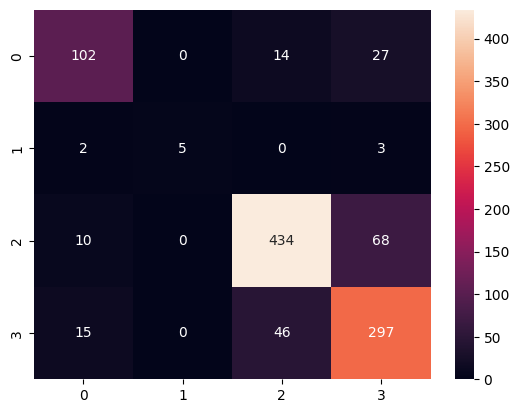

In [91]:
# Get the predicted probabilities
pred_test_probs = best_model.predict(val_data)

# Convert the predicted probabilities to class labels
pred_test = np.argmax(pred_test_probs, axis=1)

# Get the true labels
true_val = val_data.classes

# Compute the confusion matrix
cm = confusion_matrix(true_val, pred_test)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')

# Compute the classification report
val_report = classification_report(true_val, pred_test)

# Print the classification report
print(val_report)


129/129 [==============================] - 7s 55ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       574
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00      2048
           3       1.00      1.00      1.00      1434

    accuracy                           1.00      4098
   macro avg       1.00      1.00      1.00      4098
weighted avg       1.00      1.00      1.00      4098



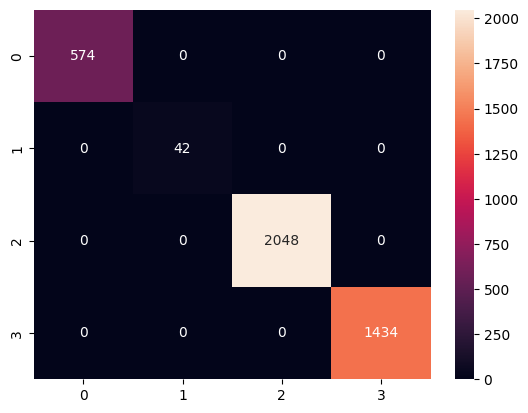

In [96]:
# Get the predicted probabilities
pred_test_probs = best_model.predict(train_data)

# Convert the predicted probabilities to class labels
pred_test = np.argmax(pred_test_probs, axis=1)

# Get the true labels
true_val = train_data.classes

# Compute the confusion matrix
cm = confusion_matrix(true_val, pred_test)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')

# Compute the classification report
val_report = classification_report(true_val, pred_test)

# Print the classification report
print(val_report)

### Test Dataset

In [97]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define path to the test directory
test_dir = "/content/Omdena/Alzheimer_s Dataset/test"

# Define image generator for test data with only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a test data flow
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(176, 176),  # Set the target size to 176x176
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # Ensure the order of the data
)

Found 1279 images belonging to 4 classes.


40/40 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.50      0.28      0.36       179
           1       1.00      0.17      0.29        12
           2       0.68      0.73      0.70       640
           3       0.54      0.58      0.56       448

    accuracy                           0.61      1279
   macro avg       0.68      0.44      0.48      1279
weighted avg       0.61      0.61      0.60      1279



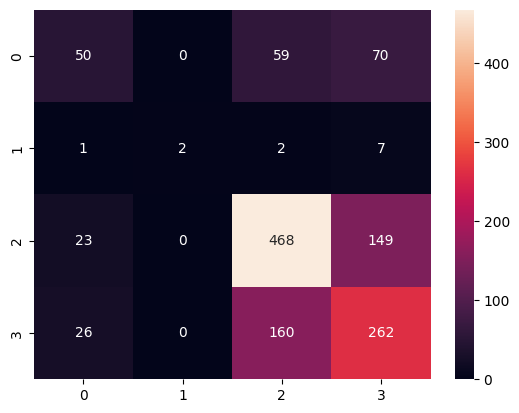

In [98]:
# Get the predicted probabilities
pred_test_probs = best_model.predict(test_data)

# Convert the predicted probabilities to class labels
pred_test = np.argmax(pred_test_probs, axis=1)

# Get the true labels
true_val = test_data.classes

# Compute the confusion matrix
cm = confusion_matrix(true_val, pred_test)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')

# Compute the classification report
val_report = classification_report(true_val, pred_test)

# Print the classification report
print(val_report)
